# Perceptron, XOR(exclusive OR)

In [30]:
# need library
import numpy as np
import tensorflow as tf
# warning remove
if type(tf.contrib) != type(tf):
    tf.contrib._warning = None
# 딥러닝 구동에 필요한 케라스 함수
from keras.models import Sequential
from keras.layers import Dense   

Using TensorFlow backend.


## XOR problem

In [31]:
import numpy as np

# weight and bias
w11 = np.array([-2,-2])
w12 = np.array([2,2])
w2 = np.array([1,1])
b1 = 3
b2 = -1
b3 = -1

# perceptron function
def MLP(x, w, b):
    y = np.sum(w * x) + b
    if y <= 0:
        return 0
    else:
        return 1
    
# NAND(not AND) gate
def NAND(x1, x2):
    return MLP(np.array([x1, x2]), w11, b1)
# OR gate : 둘 중 하나라도 1이면 1, 그렇지 않으면 0
def OR(x1, x2):
    return MLP(np.array([x1, x2]), w12, b2)
# AND gate : 두가지 모두 1이면 1, 그렇지 않으면 0
def AND(x1, x2):
    return MLP(np.array([x1, x2]), w2, b3)
# XOR gate
def XOR(x1, x2):
    return AND(NAND(x1, x2), OR(x1, x2))

if __name__=='__main__':
    for x in [(0,0),(1,0),(0,1),(1,1)]:
        y = XOR(x[0], x[1])
        print("입력 값: " + str(x) + "출력 값: " + str(y))

입력 값: (0, 0)출력 값: 0
입력 값: (1, 0)출력 값: 1
입력 값: (0, 1)출력 값: 1
입력 값: (1, 1)출력 값: 0


## XOR, Back Propogation (오차역전파)

- W(t+1) = W(t) - alpha * (partial/partialW)E 
- alpha : learning rate , E : error
- Reference: http://arctrix.com/nas/python/bpnn.py (Neil Schemenauer)  

In [32]:
import random
import numpy as np

random.seed(777)

# 환경 변수 지정

# input and target (XOR example)
data = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]

# 실행 횟수(iterations), 학습률(lr), 모멘텀 계수(mo) 설정
iterations=5000
lr=0.1
mo=0.9

# 활성화 함수 - 1. 시그모이드
# 미분할 때와 아닐 때의 각각의 값 
def sigmoid(x, derivative=False):
    if (derivative == True):
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

# 활성화 함수 - 2. tanh
# tanh 함수의 미분은 1 - (활성화 함수 출력의 제곱)
def tanh(x, derivative=False):
    if (derivative == True):
        return 1 - x ** 2
    return np.tanh(x)

# 가중치 배열 만드는 함수
def makeMatrix(i, j, fill=0.0):
    mat = []
    for i in range(i):
        mat.append([fill] * j)
    return mat

# 신경망의 실행
class NeuralNetwork:

    # 초깃값의 지정
    def __init__(self, num_x, num_yh, num_yo, bias=1):

        # 입력값(num_x), 은닉층 초깃값(num_yh), 출력층 초깃값(num_yo), 편향(bias)
        self.num_x = num_x + bias  # 편향은 1로 지정 (상수를 미분하면 0이기 때문에 계산이 간단한 1로 지정)
        self.num_yh = num_yh
        self.num_yo = num_yo

        # 활성화 함수 초깃값
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo

        # 가중치 입력 초깃값
        self.weight_in = makeMatrix(self.num_x, self.num_yh)
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random()

        # 가중치 출력 초깃값
        self.weight_out = makeMatrix(self.num_yh, self.num_yo)
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()

        # Momentum SGD를 위한 이전 가중치 초깃값
        self.gradient_in = makeMatrix(self.num_x, self.num_yh)
        self.gradient_out = makeMatrix(self.num_yh, self.num_yo)

    # 업데이트 함수
    def update(self, inputs):

        # 입력 레이어의 활성화 함수
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i]

        # 은닉층의 활성화 함수
        for j in range(self.num_yh):
            sum = 0.0
            for i in range(self.num_x):
                sum = sum + self.activation_input[i] * self.weight_in[i][j]
            # 시그모이드와 tanh 중에서 활성화 함수 선택
            self.activation_hidden[j] = tanh(sum, False)

        # 출력층의 활성화 함수
        for k in range(self.num_yo):
            sum = 0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            # 시그모이드와 tanh 중에서 활성화 함수 선택
            self.activation_out[k] = tanh(sum, False)

        return self.activation_out[:]
    
    # 역전파의 실행
    def backPropagate(self, targets):

        # 델타 출력 계산
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = targets[k] - self.activation_out[k]
            # 시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            output_deltas[k] = tanh(self.activation_out[k], True) * error

        # 은닉 노드의 오차 함수
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error = 0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k] * self.weight_out[j][k]
            # 시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            hidden_deltas[j] = tanh(self.activation_hidden[j], True) * error

        # 출력 가중치 업데이트
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k] * self.activation_hidden[j]
                v = mo * self.gradient_in[j][k] - lr * gradient
                self.weight_in[j][k] += v
                self.gradient_out[j][k] = gradient

        # 입력 가중치 업데이트
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i]
                v = mo*self.gradient_in[i][j] - lr * gradient
                self.weight_in[i][j] += v
                self.gradient_in[i][j] = gradient

        # 오차의 계산(최소 제곱법)
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k]) ** 2
        return error

    # 학습 실행
    def train(self, patterns):
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets)
            if i % 500 == 0:
                print('error: %-.5f' % error)
    # 결과 출력
    def result(self, patterns):
        for p in patterns:
            print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))

if __name__ == '__main__':

    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 2, 1)
    # 학습 실행
    n.train(data)
    # 결과값 출력
    n.result(data)

error: 0.67409
error: 0.00908
error: 0.00629
error: 0.00534
error: 0.00485
error: 0.00456
error: 0.00437
error: 0.00424
error: 0.00414
error: 0.00407
Input: [0, 0], Predict: [0.02205037348028232]
Input: [0, 1], Predict: [0.9397971425282383]
Input: [1, 0], Predict: [0.9421145997321853]
Input: [1, 1], Predict: [0.024052645439017865]


## Advanced Stochastic Gradient Descent

### Momentum
- python
  - v = m * v - learning_rate * gradient
  - self.weight[i] += v
- keras
  - keras.optimizers.SGD(lr=0.1, momentum=0.9)

### Nesterov Momentum
- python
  - v = m * v - learning_rate * gradient(Self.weight[i-1] + m * v)
  - self.weight[i] += v
- keras
  - keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)

### Adagrad
- python
  - g += gradient ** 2
  - self.weight[i] += - learning_rate * gradient / (np.sqrt(g) + e) 
- keras
  - keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6)

### RMSprop
- python
  - g = gamma * g + (1 - gamma) * gradient ** 2
  - self.weight[i] += - learning_rate * gradient / (np.sqrt(g) + e)
- keras
  - keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

### Adam
- python
  - v = gamma1 * m + (1 - gamma1) * dx
  - g = gamma2 * v + (1 - gamma2) * (dx ** 2)
  - x += - learning_rate * g / (np.sqrt(v) + e)
- keras
  - keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

## 주요 활성화 함수

### sigmoid

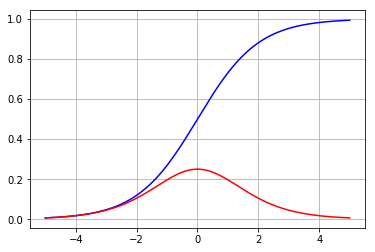

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def derivative_sigmoid(x): 
    return sigmoid(x) * (1-sigmoid(x))

X = np.linspace(-5,5,1001)
sig_Y = sigmoid(X)
derivative_sig_Y = derivative_sigmoid(X)

plt.plot(X, sig_Y, color='b')
plt.plot(X, derivative_sig_Y, color='r')
plt.grid()
plt.show()

### hyperbolic tangent

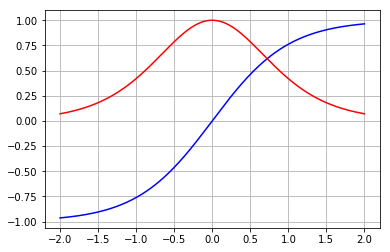

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(x):
    return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
def derivative_tanh(x): 
    return 1 - tanh(x)**2

X = np.linspace(-2,2,1001)
tanh_Y = tanh(X)
derivative_tanh_Y = derivative_tanh(X)

plt.plot(X, tanh_Y, color='b')
plt.plot(X, derivative_tanh_Y, color='r')
plt.grid()
plt.show()

### softplus

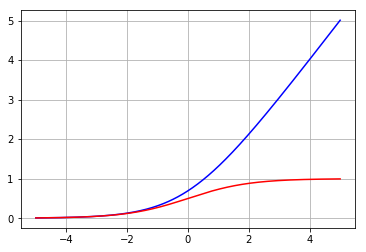

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def softplus(x):
    return np.log(1 + np.exp(x))
def derivative_softplus(x): 
    return np.exp(x) / (1 + np.exp(x))

X = np.linspace(-5,5,1001)
softplus_Y = softplus(X)
derivative_softplus_Y = derivative_softplus(X)

plt.plot(X, softplus_Y, color='b')
plt.plot(X, derivative_softplus_Y, color='r')
plt.grid()
plt.show()

### relu

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def relu(x):
    if x > 0:
        return x
    else:
        return 0
def derivative_relu(x): 
    if x > 0:
        return 1
    else:
        return 0

X = np.linspace(-1,1,1001)
relu_Y = relu(X)
derivative_relu_Y = derivative_relu(X)

plt.plot(X, relu_Y, color='b')
plt.plot(X, derivative_relu_Y, color='r')
plt.grid()
plt.show()